# Exploring Rules Extraction for Sport Image Classification

**Introduction:**

Welcome to HES-Xplain, our interactive platform designed to facilitate explainable artificial intelligence (XAI) techniques. In this `demo`, we dive into sport image classification and showcase the power of Rules Extraction as an interpretability tool.

Rules Extraction allow us to reduce the complexity of the CNN (fully-connected layers) to a small set of relevant rules, without a great loss in accuracy. Furthermore, these rules can be interpreted by looking at how they split the input data. Such a combined analysis helps us to better understand the global behavior of the network.

The library implementation and this demo mostly follow the paper [Improving neural network interpretability via rule extraction](https://arodes.hes-so.ch/record/4647?ln=fr). And aim at replacing the fully-connected layers of a Convolutional Neural Network (CNN) with a small set of rules, allowing for better interpretation of its decisions while preserving accuracy. It create Ensemble Rule based binary classifier that is able to discriminate between a target class versus others. 

With our [rules-extraction library](https://github.com/HES-XPLAIN/rules-extraction), you can effortlessly extract rules from a CNN model and seamlessly utilize this ensemble of rules in a manner compatible with the scikit-learn API. You can also create plot that illustrate the data and rules. 

Our goal is to demonstrate how HES-Xplain empowers users to explore and interpret sport image classifiers effectively. We'll focus on a specific image classification task using a pre-trained model. By the end of this demo, you'll have a solid understanding of Rules Extraction and how to integrate it into your own image classification projects using the `rules-extraction` library.

**Objectives:**

1. Understand the importance of interpretability in sport image classification.
2. Introduce Rules Extraction methods and API.
3. Showcase the capabilities of HES-Xplain in implementing Rules Extraction.
4. Provide practical insights into applying Rules Extraction to sport image classifiers through an interactive notebook.
5. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

1. Dataset and Problem Statement.
2. Loading a CNN model
3. Extract rules
4. Create rule based model
5. Rules Extraction results and plots.
6. Conclusion.
7. References.

Through this use case, we aim to empower users to grasp the potential of Rule Extraction as a tool for transparent and interpretable sport image classification. With HES-Xplain, we make XAI accessible, helping users build trust in their models and make informed decisions.

## Dataset and Problem Statement

The sport image classification dataset used in this use case consists of approximately 15,000 images, covering 100 different sports categories. This dataset, available on [Kaggle](https://www.kaggle.com/datasets/gpiosenka/sports-classification), contains a total of 13,493 train images, 500 test images, and 500 validation images. The images are in JPG format and have dimensions of 224x224 pixels with 3 color channels.

**Download dataset**: To make a propoer use of this demo, the dataset will be automatically downloaded and extracted in the data folder. You can download it using the next cell or from our [Hugging Face repository](https://huggingface.co/datasets/HES-XPLAIN/SportsImageClassification).

**Problem Statement**: Our objective is to build a robust image classifier capable of accurately classifying sport images among the 100 predefined sports categories. The nature of the dataset, comprising images of various sports, makes it particularly suitable for introducing and visualizing XAI techniques.

In [ ]:
import sys
import os

# GitHub Codespace compatibility
if 'use_case_sport_classification' not in sys.path[0]:
    root_path = os.path.join(sys.path[0], 'use_case_sport_classification')
    sys.path.append(root_path)
    os.chdir(root_path)

In [1]:
# global imports 

from rules_extraction.rules import Rule, EnsembleRule, RuleRanker
from rules_extraction.plot import plot_accuracy, plot_frontier
from rules_extraction.utils import *

from scripts.models import FineTunedVGG
from scripts.custom_dataset import CustomDataset
from scripts.helpers import *

import torch
import json
import torch.nn as nn
import pandas as pd

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset

In [2]:
# download and extract dataset

import zipfile
from huggingface_hub import hf_hub_download

REPO_ID = "HES-XPLAIN/SportsImageClassification"
FILENAME = "SportsImageClassification.zip"
dataset_file_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, repo_type="dataset")
extract_path = 'data'

# Unzip the file
with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset successfully extracted to: {extract_path}")

/home/remy/code/HES-XPLAIN/notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset successfully extracted to: data


## Loading a CNN model

**Model Weights**: We provide weights for a fine-tuned VGG on the SportsImageDataset. You can download it using the next cell or from our [Hugging Face repository](https://huggingface.co/HES-XPLAIN). While using Github Codespace you can have direct access to the weight in the folder `./models_weight`.

**Loading Weights** : By utilizing the functions and classes defined in our helpers file, you can initialize a VGG model and load the weights.

---
Utilize GPU and CUDA for faster processing speed and load the weight

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("CUDA (GPU) not available. Using CPU.")

# load trained model VGG
model = FineTunedVGG()
model = model.to(device)
model.eval()

# Specify the map_location argument when loading the model
load_path = "models_weight/VGGFineTuned.pth"
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# get loaders  using function define in scripts for this notebook
train_loader, valid_loader, test_loader = get_dataloaders()

# get a dictionary that links class names to integers, making it easier for us as we proceed in the notebook
with open('./data/idx_to_names.json', 'r') as file:
    idx_to_names = json.load(file)
names_to_idx = {v: k for k, v in idx_to_names.items()}

Using CUDA (GPU)


## Rules extraction

From this point, we'll utilize class and functions from the rules-extraction python library, accessible on our [HES-XPLAIN platform](https://github.com/HES-XPLAIN) and the [pypi index](https://pypi.org/project/rules-extraction).

**Filter dataset**: Let's create a filtered version of the data. To do this we will initialize a dataloader using only the subset of data that are correctly classified by the CNN model. This is not mandatory but it allow us to establish the CNN's performane as the ground truth. This step enable us to assess the extent of deviation between our simplification and the standard model. We can use the `rules_extraction.utils.filter_dataset` function to get the list of well classified data index. From this we can initialize a new loader.

**Compute image representation**: The rules are derived from an image representation generated by the model, specifically the final feature map of the CNN. This feature map is averaged to yield a vector, providing a condensed representation of the image. The functions `rules_extraction.utils.compute_avg_features` implement this logic and returns a dataframe.

**Create a target class dataset**: The Ensemble Rules model will be able to perform binary classification, thus we need to parse the dataset to create a binary dataset containing N datapoints of target class and N of random other class. This allow to have a balance dataset.

**Extract rules**: Once we got the image representation we can extract rules from a RandomForestClassifier model using the `rules_extraction.utils.extract_all_rules` function. You have the flexibility to pass parameters to customize your Random Forest model as needed. We recommend using `max_depth=2` to ensure the rules remain understandable.

**Rank Rules**: To reduce complexity we can rank rules and we will later use only some of the top ranked rules to. This method use a simple percpetron and use weight to classify rules importance. The logic is encapsulated in the `rules_extraction.rules.RuleRanker.rank_rules` method.l.

In [4]:
# create filtered loaders

model = model
loader = test_loader
device = device 

# test set
correct_test_idx = filter_dataset(model=model, loader=loader, device=device)
test_filtered_dataset = Subset(test_loader.dataset, correct_test_idx)
test_filtered_dataloader = DataLoader(dataset=test_filtered_dataset, batch_size=test_loader.batch_size, shuffle=False)

loader = train_loader
#train set
correct_train_idx = filter_dataset(model=model, loader=loader, device=device)
train_filtered_dataset = Subset(train_loader.dataset, correct_train_idx)
train_filtered_dataloader = DataLoader(dataset=train_filtered_dataset, batch_size=train_loader.batch_size, shuffle=False)

In [5]:
# compute avg features map 

test_features = compute_avg_features(model, test_filtered_dataloader, idx_to_names, device)
train_features = compute_avg_features(model, train_filtered_dataloader, idx_to_names, device)

test_features

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,label,path
0,0.161594,0.652690,0.047538,1.064093,1.380467,0.253600,0.188351,0.079079,0.056029,0.353060,...,1.133085,0.000000,0.003974,0.065357,0.069177,1.791595,0.107315,0.029014,air hockey,./data/test/air hockey/1.jpg
1,0.390240,0.254629,0.067557,0.811519,0.923484,0.189460,0.205537,0.043311,0.122793,0.316671,...,0.160235,0.035797,0.002228,0.308082,0.615461,0.202283,0.714211,1.398182,air hockey,./data/test/air hockey/2.jpg
2,0.112210,0.908525,0.202594,1.055019,0.141388,0.580610,0.387526,0.068631,0.019789,0.368572,...,0.201398,0.232948,0.019118,0.198524,0.120154,0.598514,0.198115,0.102653,air hockey,./data/test/air hockey/3.jpg
3,0.012094,0.189078,0.096087,0.585433,0.990634,0.709238,0.222737,0.098374,0.394360,0.380733,...,0.977582,0.238759,0.000000,0.471315,0.422341,1.358358,0.158535,0.018279,air hockey,./data/test/air hockey/4.jpg
4,0.161071,0.841154,0.093141,1.253715,0.361008,0.424310,0.014372,0.225044,0.025372,0.000000,...,0.186426,0.060410,0.086719,0.144559,0.294658,0.923876,0.118825,0.654480,air hockey,./data/test/air hockey/5.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0.535825,1.350183,0.206102,0.058937,0.443638,0.024776,1.918266,0.115086,0.000000,0.020960,...,0.508031,0.528279,0.000000,0.081718,0.182049,0.559440,0.078653,0.488618,wingsuit flying,./data/test/wingsuit flying/1.jpg
447,0.125339,0.151434,0.181230,0.100678,0.808514,0.005068,0.512090,0.011616,0.077881,0.252088,...,0.886800,0.052495,0.021441,0.103612,0.185619,0.359093,0.347735,0.092772,wingsuit flying,./data/test/wingsuit flying/2.jpg
448,0.332628,0.686316,0.032681,0.637679,0.658138,0.230646,0.373721,0.006998,0.037683,0.048818,...,0.097546,0.008654,0.000000,0.070081,0.234814,0.700230,0.036180,0.212684,wingsuit flying,./data/test/wingsuit flying/3.jpg
449,0.551912,1.066818,0.058578,0.493634,0.488581,0.000761,0.608039,0.172866,0.037819,0.575071,...,0.815722,0.284435,0.000000,0.268955,0.277530,0.361246,0.000000,0.919311,wingsuit flying,./data/test/wingsuit flying/4.jpg


As you can see, our dataframe now represents each image with a vector of 512 floats. These vectors are obtained by averaging the last feature map of VGG.

---
As mentioned earlier, our current task involves binary classification, specifically targeting the classification of one specific category against the rest. To achieve this, we must dynamically parse our dataframe and generate a binary dataset on the fly. 

For this, we select a target class of interest and employ the function rules_extraction.utils.make_target_df. This function returns a dataframe containing all the data for the target class, while also sampling from other classes to create a balanced dataset.

Let's investigate the 'air hockey' class. 

In [6]:
df_test = make_target_df(test_features, 'air hockey')
df_train = make_target_df(train_features, 'air hockey')
X_train, y_train = df_train.iloc[:, :-3], df_train.iloc[:, -1]
X_test, y_test = df_test.iloc[:, :-3], df_test.iloc[:, -1]

In [7]:
# extract all rules from a RandomForestClassifier
all_rules = extract_all_rules(X_train, y_train, n_estimators=200, max_depth=2, random_state=1)

In [8]:
# rank rules extract only the top 30 
top_30_rules = RuleRanker(all_rules, X_train, y_train).rank_rules(N=30)

## Create rule based model 

**Ensemble Rule Modeling**: 

Once the rules are ranked, we can make use of our rule classifier API. To begin, we initialize individual rules using our simple rule class and then select the top N rules to initialize the EnsembleRule classifier.

Both the Rule and EnsembleRule are designed to be compatible with the scikit-learn API. They implement the .fit, .predict, and .score methods.

In [9]:
# Extract conditions and labels from the list and initialize a list of Rule
conditions_list, labels_list = zip(*top_30_rules)
rules = [Rule(conditions, label) for conditions, label in zip(conditions_list, labels_list)]

# Initialize ensemble rule
ensemble_rule = EnsembleRule(rules)

# Predict with ensemble rule
data_point = df_test.iloc[0]
ensemble_prediction = ensemble_rule.predict(data_point)
print(f"Ensemble Rule Prediction: {ensemble_prediction[0]} the correct prediction is {data_point['binary_label']}")

Ensemble Rule Prediction: 1 the correct prediction is 1


## Rules Extraction results and plots.

**Prediction and score**: We can use ensemble.predict or rule.predict to make prediction on one or multiple data points and use the ensemble.score or rule.score method to compute the accuracy. 

**Plots**: The `rules_extraction.plot` API enable two plots. 

1. Plot accuracy: where you can compute and plot the accuracy on a dataset versus the number of rules used. This show how adding rules improve the model. Usually we can see that from two to three rules our EnsembleRule classifier is able to achieve 80-90% accuracy.

2. Plot frontier: this plot show a rule for one class with example images and plot the rule's frontier. Images are embedded according to their average filter activation. The most characteristic images of the class are grouped together as they have similar filter activations. We can also get the intuition for visual patterns that are present in one class but absent in all other classes.

In [10]:
ensemble_predictions = ensemble_rule.predict(X_test)
print(f"Ensemble Rule predictions on test set are: {ensemble_predictions}. And the correct predictions are {y_test.tolist()}")
print(f"Accuracy on test set: {ensemble_rule.score(X_test, y_test):.3f}")

Ensemble Rule predictions on test set are: [1 1 1 1 1 0 0 0 0 0]. And the correct predictions are [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy on test set: 1.000


---
Let's do some plots now: the `rules_extraction.plot` API enable two plots. 

1. Plot accuracy: where you can compute and plot the accuracy on a dataset versus the number of rules used. This show how adding rules improve the model. Usually we can see that from two to three rules our EnsembleRule classifier is able to achieve 80-90% accuracy.

2. Plot frontier: this plot show a rule for one class with example images and plot the rule's frontier. Images are embedded 
according to their average filter activation The most characteristic images of the class are grouped together as they have 
similar filter activations. We can also get th  intuition for visual patterns tha 
are present in one class but absent in all other classes..

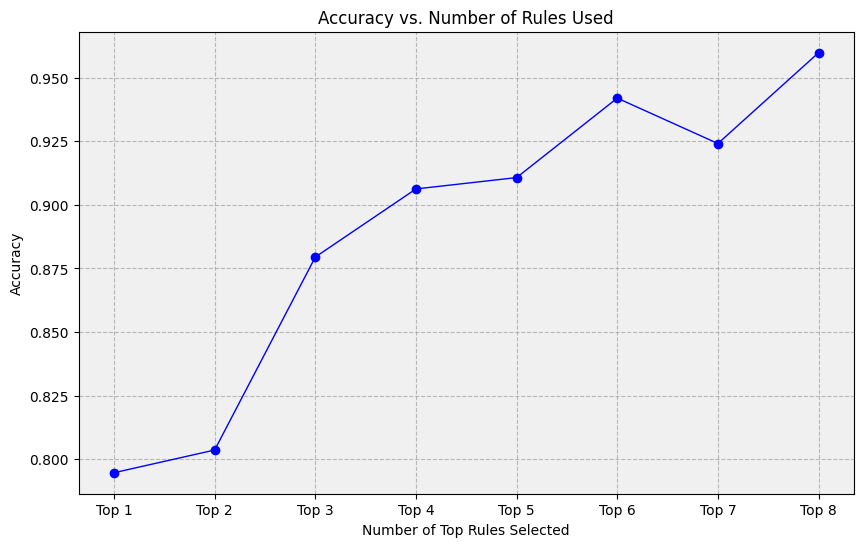

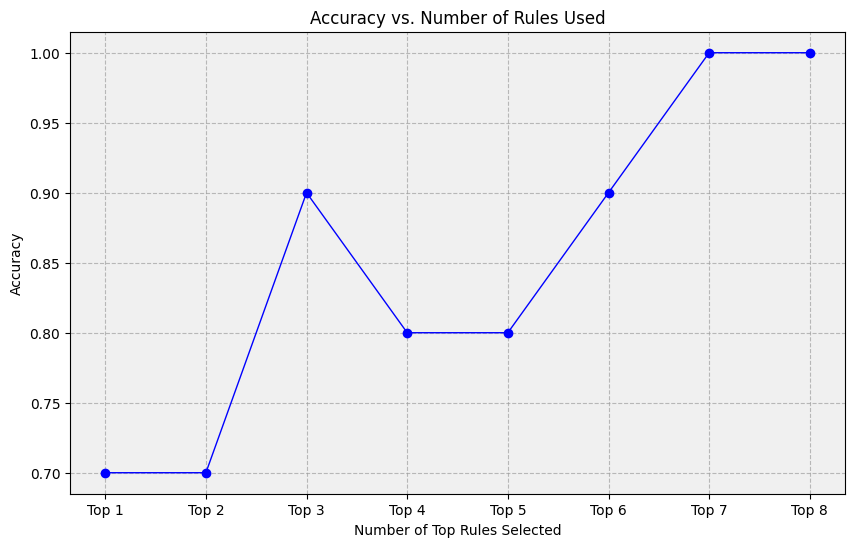

In [11]:
plot_accuracy(rules, df_train, class_name=None, n=9, save_path=None)
plot_accuracy(rules, df_test, class_name=None, n=9, save_path=None)


/home/remy/code/HES-XPLAIN/notebooks/.venv/lib/python3.11/site-packages/rules_extraction/plot.py:127: RuntimeWarning: invalid value encountered in divide
  normalized_map = (resized_feature_map - resized_feature_map.min()) / (


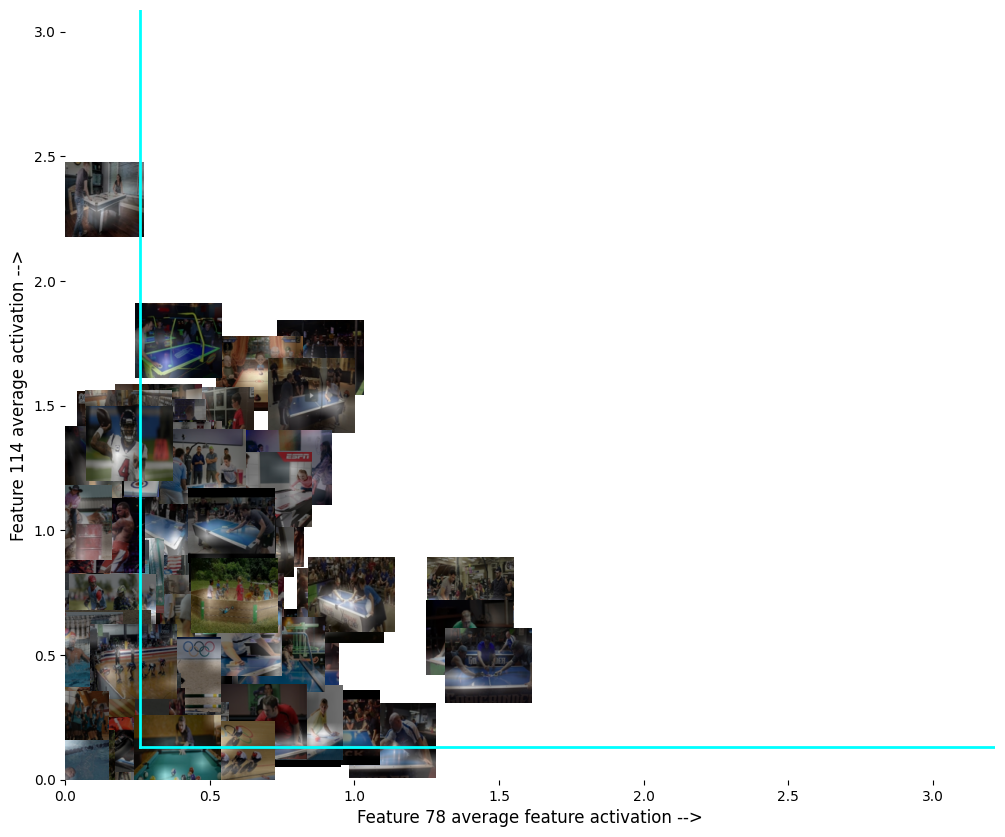

In [12]:
plot_frontier(train_features, rule=rules[1], target_class='air hockey', model=model, alpha=0.55, device=device)

## Conclusion:

Throughout this notebook, we demonstrate the application of our rules-extraction library for extracting rules from a convolutional model. Additionally, we illustrate how to use these rules to make predictions employing a simpler and more interpretable model.

Utilizing an ensemble of rule-based models empowers users to have control over their predictions and offers potential explanations. Although average features may not be directly understandable by humans, they contribute to reducing the complexity of a CNN. Further exploration can be undertaken to delve into the significant features, including those used by the top rule.

Furthermore, by employing the frontier plot, we aim to gain intuition into visual patterns that are present in one class but absent in all other classes. This approach contributes to enhancing the explainability of the CNN model. 

## References

1. [Rule Extraction paper](https://arodes.hes-so.ch/record/4647?ln=fr)
2. [Scikit-learn](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)
